# Masters 2026 Prediction Modeling

What if the secret to mastering Augusta isn’t just instinct or experience, but data? This project investigates that idea by applying statistical modeling to uncover the skills that truly separate top performers from the field at golf’s most iconic and demanding tournament.

Throughout this notebook, I use Masters Tournament and Augusta National interchangeably - they refer to the same event, since the Masters is held annually at Augusta National Golf Club in Georgia. In this notebook, I go from **understanding the Masters Tournament** to **predicting the 2026 Masters leaderboard**.

## **Part 1**
Using event-level strokes gained data from the 2021–2025 Masters, I answer:

> **Which strokes-gained components (off the tee, approach, around the green, putting) matter the most for scoring at Augusta National?**

### Features Used:
- **sg_putt** = shots gained on putting

Masters greens are fast and undulating. Putting is a key driver of scoring variation, especially on Sunday.

- **sg_arg** = shots gained around the green (any shot within 30 yards of the edge of the green)

Missed greens are common, and tight run-offs punish poor short game. Around-the-green performance helps distinguish players who can still save par when they miss the green.

- **sg_app** = shots gained on approach (all shots that are not from the tee on par 4 and par 5 holes and are not included in sg_arg and sg_putt; includes tee shots on par 3s)

Augusta’s greens are heavily contoured and elevated. Approaches that finish on the right tiers are critical, so approach play is strongly related to scoring.

- **sg_ott** = shots gained off the tee (all shots off the tee on par 4s and 5s)

At Augusta, long and accurate drives create easier approach shots on par 5s and longer par 4s.

Overall, these features were chosen because they have a clear golf explanation for why they should affect scoring at Augusta. Also, they are widely used and understood in golf, making the results more interpretable. They focus on skill rather than outcome variables (like score itself), which helps with generalization.
- I exclude SG Tee-to-Green (T2G) because it is a composite of OTT, APP, and ARG and would confound the analysis.
- I fit both a **linear regression** and a **LASSO regression** to quantify the impact of each SG component on total score relative to par (`TotalToPar`).

## 1. Setup

In [32]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [33]:
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names: lowercase, underscores, no dashes."""
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("-", "_")
    )
    return df

def clean_player_name(name: str) -> str:
    """Normalize player names and handle 'Last, First' formats."""
    if pd.isna(name):
        return name
    name = str(name).strip()
    # Convert 'Last, First' → 'First Last'
    if "," in name:
        last, first = [x.strip() for x in name.split(",", 1)]
        return f"{first} {last}"
    return name


## 2. Load and Clean Masters Historical Data (2021–2025)

In [34]:
masters_paths = [
    "2021_masters_tournament_event_values.csv",
    "2022_masters_tournament_event_values.csv",
    "2023_masters_tournament_event_values.csv",
    "2024_masters_tournament_event_values.csv",
    "2025_masters_tournament_event_values.csv",
]

masters_list = []
for path in masters_paths:
    year = int(os.path.basename(path)[:4])
    df = pd.read_csv(path)
    df = clean_columns(df)
    # Standardize player name
    df["player"] = df["player_name"].apply(clean_player_name)
    df["year"] = year
    masters_list.append(df)

masters_df = pd.concat(masters_list, ignore_index=True)

# Drop composite T2G and any total SG column — we only want the four atomic components
masters_df = masters_df.drop(columns=["sg_t2g", "sg_total"], errors="ignore")

masters_df.head()


,position,player_name,total_score,r4_score,sg_putt,sg_arg,sg_app,sg_ott,player,year
0,1,"Matsuyama, Hideki",-10,1.0,0.226,1.401,1.500,0.350,Hideki Matsuyama,2021
1,2,"Zalatoris, Will",-9,-2.0,1.216,0.067,0.968,0.976,Will Zalatoris,2021
2,T3,"Schauffele, Xander",-7,0.0,-0.267,1.512,0.651,0.831,Xander Schauffele,2021
3,T3,"Spieth, Jordan",-7,-2.0,-0.876,1.699,1.119,0.785,Jordan Spieth,2021
4,T5,"Rahm, Jon",-6,-6.0,0.084,0.884,-0.197,1.705,Jon Rahm,2021


### 2.1 Handle Missing Values and Define Features

In [35]:
feature_cols = ["sg_ott", "sg_app", "sg_arg", "sg_putt"]

print("Missing values per column:")
print(masters_df[feature_cols + ["total_score"]].isna().sum())

# Drop rows with any missing SG or target values
masters_clean = masters_df.dropna(subset=feature_cols + ["total_score"]).copy()

print("\nShape before cleaning:", masters_df.shape)
print("Shape after cleaning:", masters_clean.shape)

masters_clean[feature_cols + ["total_score"]].head()


Missing values per column:
sg_ott         1
sg_app         1
sg_arg         1
sg_putt        1
total_score    0
dtype: int64

Shape before cleaning: (448, 10)
Shape after cleaning: (447, 10)


,sg_ott,sg_app,sg_arg,sg_putt,total_score
0,0.350,1.500,1.401,0.226,-10
1,0.976,0.968,0.067,1.216,-9
2,0.831,0.651,1.512,-0.267,-7
3,0.785,1.119,1.699,-0.876,-7
4,1.705,-0.197,0.884,0.084,-6


## 3. Correlation Between Strokes Gained and Score at The Masters

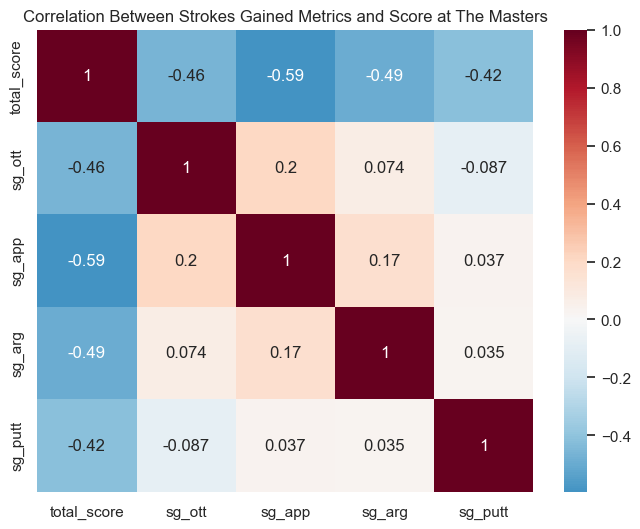

In [36]:
plt.figure(figsize=(8, 6))
corr = masters_clean[["total_score"] + feature_cols].corr()
sns.heatmap(corr, annot=True, cmap="RdBu_r", center=0)
plt.title("Correlation Between Strokes Gained Metrics and Score at The Masters")
plt.show()


## 4. Linear Regression (Direction & Magnitude of Effects)

In [37]:
X_event = masters_clean[feature_cols]
y_event = masters_clean["total_score"]

linreg = LinearRegression()
linreg.fit(X_event, y_event)

lin_coeffs = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": linreg.coef_
}).sort_values("Coefficient")

lin_coeffs


,Feature,Coefficient
2,sg_arg,-2.482137
0,sg_ott,-2.409251
3,sg_putt,-2.402874
1,sg_app,-2.254999


## 5. LASSO Regression

In [38]:
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_event, y_event, test_size=0.2, random_state=42)

lasso = Lasso(alpha=0.05)
lasso.fit(X_train_e, y_train_e)

lasso_importance = pd.DataFrame({
    "Feature": feature_cols,
    "LASSO_Weight": lasso.coef_
}).sort_values("LASSO_Weight")

lasso_importance


,Feature,LASSO_Weight
2,sg_arg,-2.514148
0,sg_ott,-2.414271
3,sg_putt,-2.383883
1,sg_app,-2.185049


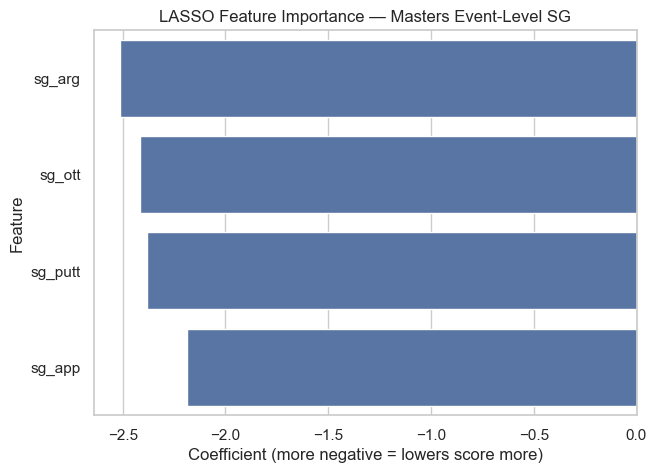

In [39]:
plt.figure(figsize=(7, 5))
sns.barplot(
    data=lasso_importance,
    x="LASSO_Weight",
    y="Feature"
)
plt.title("LASSO Feature Importance — Masters Event-Level SG")
plt.xlabel("Coefficient (more negative = lowers score more)")
plt.show()


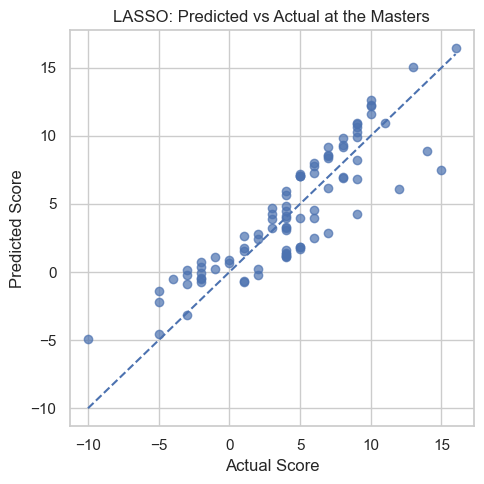

In [52]:
y_pred_lasso_event = lasso.predict(X_test_e)

plt.figure(figsize=(5, 5))
plt.scatter(y_test_e, y_pred_lasso_event, alpha=0.7)
plt.plot([y_test_e.min(), y_test_e.max()],
         [y_test_e.min(), y_test_e.max()],
         linestyle="--")
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("LASSO: Predicted vs Actual at the Masters")
plt.tight_layout()
plt.show()


## **Part 2** - Predicting the 2026 Masters Using Season-Long SG
Once I know which skills Augusta rewards, I:

1. Use the **LASSO coefficients from Stage 1** as an Augusta skill weighting over OTT/APP/ARG/PUTT.
2. Load **season-long strokes gained data** from a combined **PGA / LIV / Euro 2025** file.
3. Compute a **Masters-specific skill index** for each player based on their season-long SG profile.
4. Calibrate that index to **total score relative to par at the Masters**.
5. Generate a **projected 2026 Masters leaderboard**, sorted from lowest (best) predicted score to highest.


### 1. Build the Augusta Skill Index and Calibration Model

In [40]:
# LASSO coefficients in same order as feature_cols
beta = lasso.coef_.copy()

# Compute Augusta skill index for historical Masters players
z_event = X_event.values @ beta  # shape (n_samples,)

# Fit calibration model: total_score ~ a + b * z_event
calib_reg = LinearRegression()
calib_reg.fit(z_event.reshape(-1, 1), y_event)

a = calib_reg.intercept_
b = calib_reg.coef_[0]

a, b


(3.1920167882585178, 1.0082950235272659)

### 2. Load Season-Long Strokes Gained Data (PGA / LIV / Euro 2025)

In [41]:
sg_path = "pga_liv_euro_2025_strokes_gained_combined.csv"
sg_df_raw = pd.read_csv(sg_path)
sg_df = sg_df_raw.copy()
sg_df.columns = (
    sg_df.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)

# Standardize player names
sg_df["player"] = sg_df["player"].apply(clean_player_name)

print("Season SG columns after cleaning:")
print(sg_df.columns.tolist())

# Standardize SG column names
rename_map = {
    "ott": "sg_ott",
    "app": "sg_app",
    "arg": "sg_arg",
    "putt": "sg_putt"
}
sg_df = sg_df.rename(columns=rename_map)
season_feature_cols = ["sg_ott", "sg_app", "sg_arg", "sg_putt"]
# Keep only players with complete SG data for these four categories
sg_clean = sg_df.dropna(subset=season_feature_cols).copy()
print("\nShape before cleaning:", sg_df.shape)
print("Shape after cleaning:", sg_clean.shape)

sg_clean[["player"] + season_feature_cols].head()


Season SG columns after cleaning:
['player', 'rounds', 'putt', 'arg', 'app', 'ott', 'bs', 't2g', 'tour']

Shape before cleaning: (403, 9)
Shape after cleaning: (403, 9)


,player,sg_ott,sg_app,sg_arg,sg_putt
0,Scottie Scheffler,0.801,1.501,0.407,0.623
1,Rory McIlroy,0.821,0.537,0.249,0.709
2,Tommy Fleetwood,0.421,0.850,0.407,0.518
3,Russell Henley,0.225,0.812,0.499,0.370
4,J.J. Spaun,0.424,0.852,0.026,0.260


### 3. Apply the Augusta Model to Season SG Data

In [42]:
X_season = sg_clean[season_feature_cols].values
# Compute season-based Augusta skill index
z_season = X_season @ beta

# Predicted Masters total score relative to par
yhat_season = calib_reg.predict(z_season.reshape(-1, 1))
pred_df = sg_clean.copy()
pred_df["PredictedScore"] = yhat_season

# Lower score = better performance
leaderboard = pred_df[["player", "PredictedScore"]].sort_values("PredictedScore")
leaderboard.head(15)


,player,PredictedScore
0,Scottie Scheffler,-4.594045
1,Rory McIlroy,-2.325055
2,Tommy Fleetwood,-1.982362
200,Jon Rahm,-1.860060
3,Russell Henley,-1.298997
201,Bryson DeChambeau,-0.651103
202,Joaquin Niemann,-0.577169
5,Ben Griffin,-0.427771
4,J.J. Spaun,-0.408091
7,Justin Thomas,-0.398169


### 4. Output: Predicted 2026 Masters Leaderboard

In [43]:
out_path = "masters_2026_predicted.csv"
leaderboard.to_csv(out_path, index=False)
out_path


'masters_2026_predicted.csv'

In [44]:
# Train XGBoost on the same event-level features used for LASSO
xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)

xgb.fit(X_train_e, y_train_e)

# Evaluate on held-out Masters data
y_pred_xgb_event = xgb.predict(X_test_e)
mae_xgb = mean_absolute_error(y_test_e, y_pred_xgb_event)
rmse_xgb = root_mean_squared_error(y_test_e, y_pred_xgb_event)

mae_xgb, rmse_xgb

(2.1479557224445873, 2.6079170423296887)

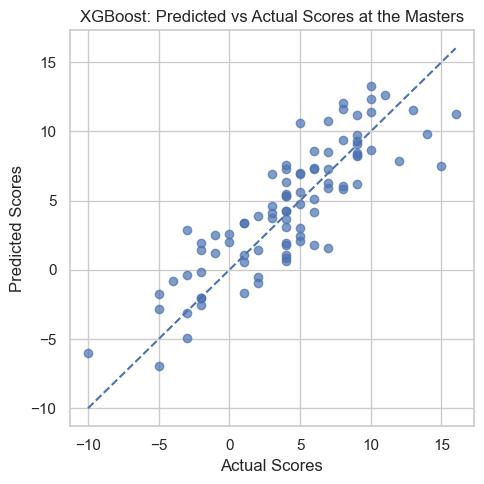

In [49]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test_e, y_pred_xgb_event, alpha=0.7)
plt.plot([y_test_e.min(), y_test_e.max()],
         [y_test_e.min(), y_test_e.max()],
         linestyle="--")
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("XGBoost: Predicted vs Actual Scores at the Masters")
plt.tight_layout()
plt.show()

In [ ]:
# Use season-long SG features for 2025 to predict 2026 Masters scores with XGBoost
X_season_xgb = sg_clean[season_feature_cols].values
yhat_season_xgb = xgb.predict(X_season_xgb)

leaderboard_xgb = sg_clean.copy()
leaderboard_xgb["PredictedScore_XGB"] = yhat_season_xgb
leaderboard_xgb = leaderboard_xgb[["player", "PredictedScore_XGB"]].sort_values("PredictedScore_XGB")


In [46]:
xgb_out_path = "masters_2026_predicted_XGB.csv"
leaderboard_xgb.to_csv(xgb_out_path, index=False)
xgb_out_path

'masters_2026_predicted_XGB.csv'

### ***WILL ADD MORE COMMENTS AND EXPLANATIONS*** ###

### ***COMMIT FILE BECAUSE OF PRESENTATION DEADLINE*** ###